ETL Process: 
--> Import Python Package 
--> Connect to source database and define destination database in SQL server 
--> read csv file
--> concat existing data and new data
--> populate SQL table

In [239]:
import pandas as pd
import numpy as np
import os
file_path=r''

In [240]:
import pyodbc
import urllib
import sqlalchemy

'''sources databases'''
params_p = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse1;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_p = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_p))


params_s = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse2;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_s = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_s))



'''destination databases'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [241]:
df=pd.read_csv(file_path+'YR_Data.csv',parse_dates=['Date Reported','Estimated Date of Onset'])
df.shape


(98230, 9)

In [242]:
df.to_sql('gov',engine_datahub,if_exists='replace',index=False)

In [243]:
df_new=pd.read_csv(file_path+'new_data.csv',parse_dates=['Date Reported','Estimated Date of Onset'])
df_new.shape

(81, 9)

In [244]:
df_gov=pd.read_sql_table('gov',engine_datahub)
df_gov.shape

(98230, 9)

In [245]:
df_all = pd.concat([df_new,df_gov])
df_all.shape

(98311, 9)

In [246]:
# drop duplicates - no duplicates
df_all.drop_duplicates(keep='first', inplace=True)
df_all.shape

(98311, 9)

In [247]:
df_all.to_sql("gov", engine_datahub,if_exists='replace',index=False)

In [248]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98311 entries, 0 to 98229
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Case Count               98311 non-null  int64         
 1   Gender                   98311 non-null  object        
 2   Age Decade               98310 non-null  object        
 3   Municipality             98311 non-null  object        
 4   Community                98311 non-null  object        
 5   Date Reported            98311 non-null  datetime64[ns]
 6   Estimated Date of Onset  98311 non-null  datetime64[ns]
 7   Acquisition              98311 non-null  object        
 8   Status                   98311 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 7.5+ MB


In [249]:
df_all.head()

,Case Count,Gender,Age Decade,Municipality,Community,Date Reported,Estimated Date of Onset,Acquisition,Status
0,38481,Male,70s,Other,Pending Neighbourhood,2022-03-03,2022-02-28,Under Investigation,Self-Isolating
1,38484,Male,Under 20,Vaughan,Maple,2022-03-03,2022-02-28,Under Investigation,Self-Isolating
2,38490,Under Investigation,50s,Vaughan,Thornhill,2022-03-03,2022-03-03,Under Investigation,Self-Isolating
3,38616,Male,20s,King,Pending Neighbourhood,2022-03-03,2022-02-28,Under Investigation,Self-Isolating
4,38617,Male,30s,Newmarket,Pending Neighbourhood,2022-03-03,2022-02-07,Close Contact,Resolved


In [250]:
pd.DatetimeIndex(df_all['Estimated Date of Onset']).year

Int64Index([2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022,
            ...
            2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
           dtype='int64', name='Estimated Date of Onset', length=98311)

In [251]:
df_all['date_diff']=df['Date Reported']-df['Estimated Date of Onset']
df_all

,Case Count,Gender,Age Decade,Municipality,Community,Date Reported,Estimated Date of Onset,Acquisition,Status,date_diff
0,38481,Male,70s,Other,Pending Neighbourhood,2022-03-03,2022-02-28,Under Investigation,Self-Isolating,4 days
1,38484,Male,Under 20,Vaughan,Maple,2022-03-03,2022-02-28,Under Investigation,Self-Isolating,8 days
2,38490,Under Investigation,50s,Vaughan,Thornhill,2022-03-03,2022-03-03,Under Investigation,Self-Isolating,10 days
3,38616,Male,20s,King,Pending Neighbourhood,2022-03-03,2022-02-28,Under Investigation,Self-Isolating,6 days
4,38617,Male,30s,Newmarket,Pending Neighbourhood,2022-03-03,2022-02-07,Close Contact,Resolved,5 days
...,...,...,...,...,...,...,...,...,...,...
98225,38596,Female,30s,Markham,Pending Neighbourhood,2022-03-02,2022-02-26,Under Investigation,Resolved,4 days
98226,38601,Female,50s,Aurora,Pending Neighbourhood,2022-03-02,2022-02-28,Close Contact,Self-Isolating,2 days
98227,38610,Male,Under 20,Markham,Pending Neighbourhood,2022-03-02,2022-02-28,Under Investigation,Self-Isolating,2 days
98228,62574,Female,80s,Vaughan,Woodbridge,2022-03-02,2022-01-09,Institutional Outbreak,Resolved,52 days


In [252]:
df_all.describe()

,Case Count,date_diff
count,98311.000000,98311
mean,49156.000000,5 days 17:29:25.633550670
std,28380.085494,42 days 03:59:36.133233120
min,1.000000,0 days 00:00:00
25%,24578.500000,2 days 00:00:00
50%,49156.000000,4 days 00:00:00
75%,73733.500000,6 days 00:00:00
max,98311.000000,12766 days 00:00:00


In [253]:
#find the outlier
df_all.loc[df_all['date_diff'].idxmax()] 

Case Count                                 74349
Gender                                      Male
Age Decade                              Under 20
Municipality                    East Gwillimbury
Community                  Pending Neighbourhood
Date Reported                2022-02-01 00:00:00
Estimated Date of Onset      1987-02-19 00:00:00
Acquisition                  Under Investigation
Status                                  Resolved
date_diff                    12766 days 00:00:00
Name: 94877, dtype: object

In [254]:
df_all[df_all['Case Count']==74349]

,Case Count,Gender,Age Decade,Municipality,Community,Date Reported,Estimated Date of Onset,Acquisition,Status,date_diff
94877,74349,Male,Under 20,East Gwillimbury,Pending Neighbourhood,2022-02-01,1987-02-19,Under Investigation,Resolved,12766 days


In [255]:
#drop the outlier
df_all = df_all.drop(labels=94877, axis=0)

In [256]:
#external communication: 5 days is average days to show symptom, 75% of the population show symptoms in 6 days.
df_all.describe()

,Case Count,date_diff
count,98310.000000,98310
mean,49155.743739,5 days 14:22:31.235886481
std,28380.116092,11 days 00:49:13.717862464
min,1.000000,0 days 00:00:00
25%,24578.250000,2 days 00:00:00
50%,49155.500000,4 days 00:00:00
75%,73732.750000,6 days 00:00:00
max,98311.000000,734 days 00:00:00


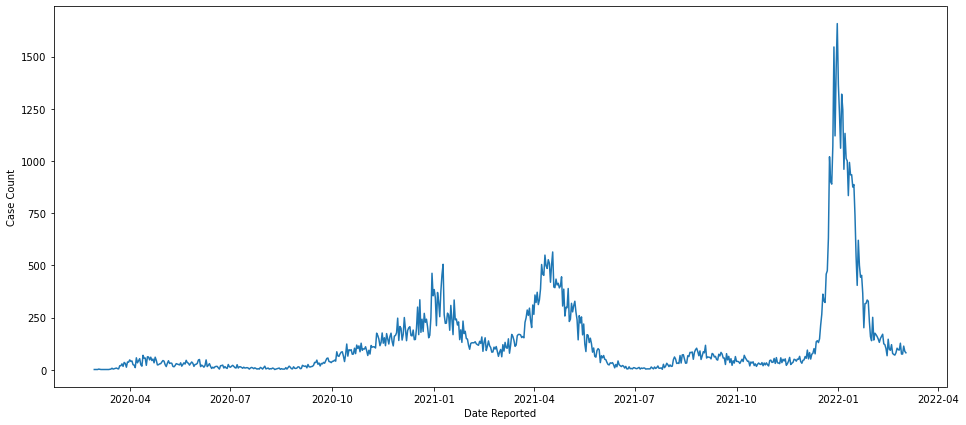

In [355]:
df_all_case_count_by_day= pd.DataFrame(df_all.groupby('Date Reported')['Case Count'].count())
plt.figure(figsize=(16,7))
sns.lineplot(x = df_all_case_count_by_day.index, y = df_all_case_count_by_day['Case Count'])
plt.show()

In [356]:
from datetime import datetime
import datetime as dt
from datetime import date
def monthly(x):
    return dt.datetime(x.year,x.month, 1)

In [357]:
df_all['Month']= df_all['Date Reported'].apply(monthly)
df_all_case_count_by_mth = pd.DataFrame(df_all.groupby('Month')['Case Count'].count())
df_all_case_count_by_mth

,Case Count
Month,
2020-02-01,1
2020-03-01,276
2020-04-01,1217
2020-05-01,877
2020-06-01,562
2020-07-01,293
2020-08-01,195
2020-09-01,789
2020-10-01,2557


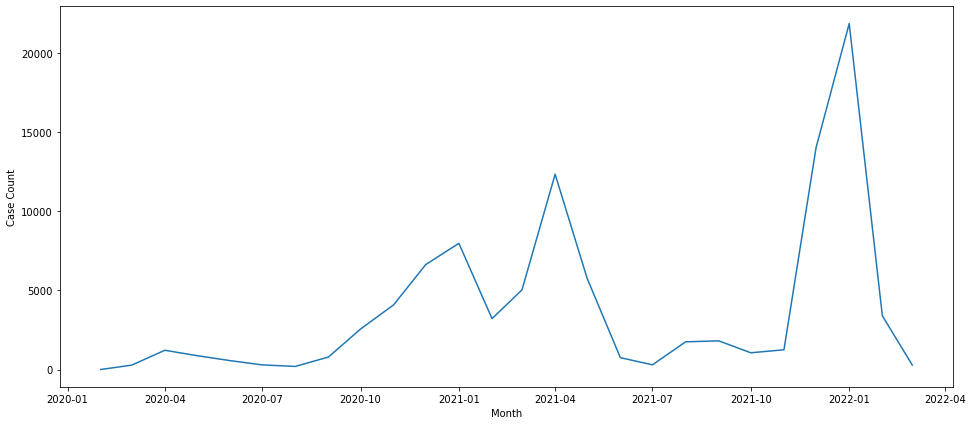

In [358]:
#external communication: case infection count time series
plt.figure(figsize=(16,7))
sns.lineplot(x = df_all_case_count.index, y = df_all_case_count['Case Count'])
plt.show()

<AxesSubplot:xlabel='Gender', ylabel='Case Count'>

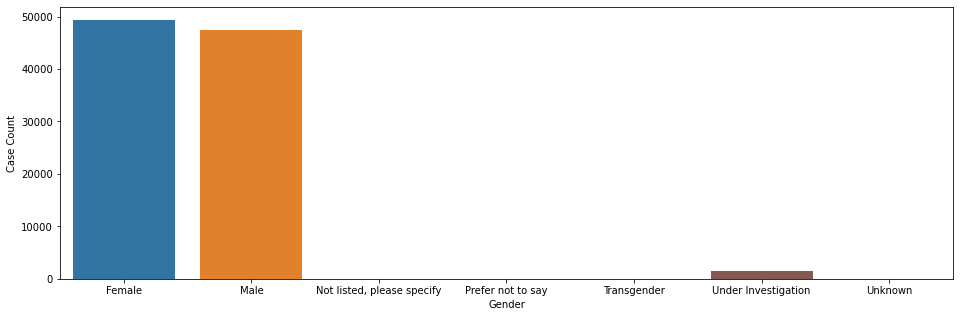

In [258]:
#external communication - no obvious gender difference in the case infection
df_all_gender = pd.DataFrame(df_all.groupby('Gender')['Case Count'].count())
df_all_gender
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=df_all_gender.index,y = 'Case Count', data = df_all_gender)

<AxesSubplot:xlabel='Municipality', ylabel='Case Count'>

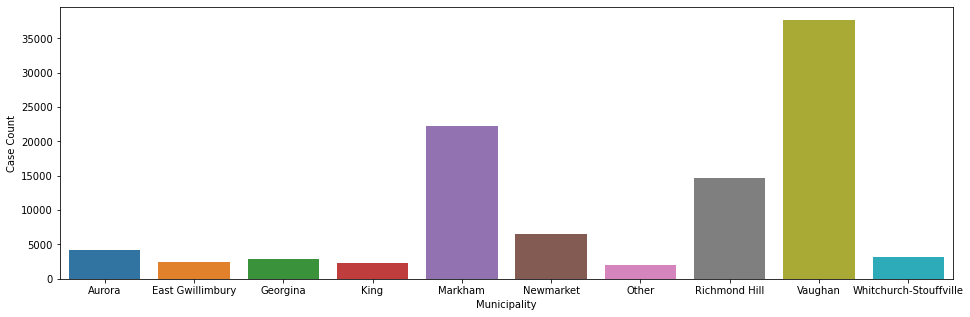

In [259]:
#internal communication - Cases in Vaughan and Markham are the higheset
df_all_municipality = pd.DataFrame(df_all.groupby('Municipality')['Case Count'].count())
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=df_all_municipality.index,y = 'Case Count', data = df_all_municipality)

In [381]:
df_all_status_area = pd.DataFrame(df_all.groupby(by=['Status','Municipality'])['Case Count'].count()).unstack()
df_all_status_area = df_all_status_area.fillna(0)
df_all_status_area

Case Count                                             \
Municipality         Aurora East Gwillimbury Georgina    King  Markham   
Status                                                                   
Deceased               61.0              9.0     62.0    23.0    200.0   
Hospitalized            0.0              1.0      0.0     1.0      2.0   
Hospitalized-ICU        0.0              0.0      0.0     0.0      0.0   
Resolved             4157.0           2415.0   2731.0  2302.0  22048.0   
Self-Isolating         20.0             41.0     24.0    16.0     66.0   

                                                           \
Municipality     Newmarket   Other Richmond Hill  Vaughan   
Status                                                      
Deceased              68.0     0.0         103.0    372.0   
Hospitalized           1.0     0.0           3.0      6.0   
Hospitalized-ICU       0.0     0.0           1.0      2.0   
Resolved            6458.0  2024.0       14467.0  37190.0   
Self-Isolating        33.0    18.0          54.0    121.0   

                                         
Municipality     Whitchurch-Stouffville  
Status                                   
Deceased                           25.0  
Hospitalized                        2.0  
Hospitalized-ICU                    0.0  
Resolved                         3161.0  
Self-Isolating                     22.0

In [382]:
df_all_status_area_transpose = df_all_status_area.transpose()
df_all_status_area_transpose

Status                             Deceased  Hospitalized  Hospitalized-ICU  \
           Municipality                                                       
Case Count Aurora                      61.0           0.0               0.0   
           East Gwillimbury             9.0           1.0               0.0   
           Georgina                    62.0           0.0               0.0   
           King                        23.0           1.0               0.0   
           Markham                    200.0           2.0               0.0   
           Newmarket                   68.0           1.0               0.0   
           Other                        0.0           0.0               0.0   
           Richmond Hill              103.0           3.0               1.0   
           Vaughan                    372.0           6.0               2.0   
           Whitchurch-Stouffville      25.0           2.0               0.0   

Status                             Resolved  Self-Isolating  
           Municipality                                      
Case Count Aurora                    4157.0            20.0  
           East Gwillimbury          2415.0            41.0  
           Georgina                  2731.0            24.0  
           King                      2302.0            16.0  
           Markham                  22048.0            66.0  
           Newmarket                 6458.0            33.0  
           Other                     2024.0            18.0  
           Richmond Hill            14467.0            54.0  
           Vaughan                  37190.0           121.0  
           Whitchurch-Stouffville    3161.0            22.0

In [384]:
city_list = df_all_status_area_transpose.index.to_list()
city_list2= []
for city in city_list:
    city_list2.append(city[1])
city_list2

['Aurora',
 'East Gwillimbury',
 'Georgina',
 'King',
 'Markham',
 'Newmarket',
 'Other',
 'Richmond Hill',
 'Vaughan',
 'Whitchurch-Stouffville']

<AxesSubplot:ylabel='Deceased'>

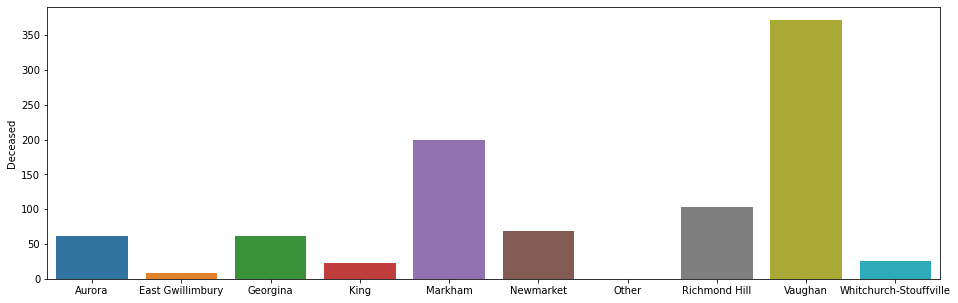

In [385]:
#internal communication - Decease rate in Vaughan and Markham are the higheset.Other area has infection cases, but no decease
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=city_list2,y =df_all_status_area_transpose['Deceased'] , data = df_all_status_area_transpose['Deceased'])

<AxesSubplot:xlabel='Acquisition', ylabel='Case Count'>

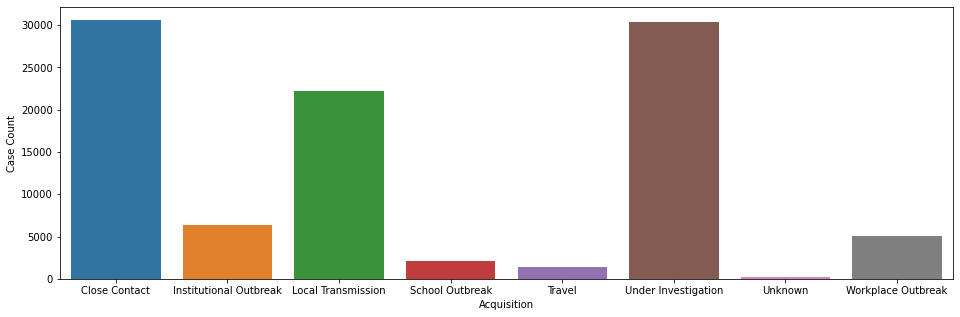

In [161]:
# external communication - 'Close contact' is the major cause of case infection
df_all_acquisition = pd.DataFrame(df_all.groupby('Acquisition')['Case Count'].count())
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=df_all_acquisition.index,y = 'Case Count', data = df_all_acquisition)

<AxesSubplot:xlabel='Status', ylabel='Case Count'>

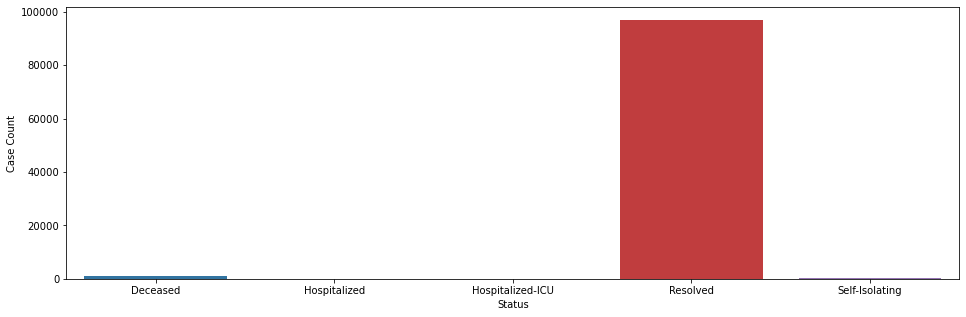

In [260]:
# external communication: infection cases can be resolved. Deceased is exceptionnal
df_all_status = pd.DataFrame(df_all.groupby('Status')['Case Count'].count())
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=df_all_status.index,y = 'Case Count', data = df_all_status)

In [261]:
df_age_group = pd.DataFrame({'Age Decade':['Under 20','20s','30s','40s','50s','60s','70s','80s','90s','100s'],
                'Age_group':[1,2,3,4,5,6,7,8,9,10]})
df_all = pd.merge(df_all,df_age_group,on = 'Age Decade',how= 'left')
df_all.head()

,Case Count,Gender,Age Decade,Municipality,Community,Date Reported,Estimated Date of Onset,Acquisition,Status,date_diff,Age_group
0,38481,Male,70s,Other,Pending Neighbourhood,2022-03-03,2022-02-28,Under Investigation,Self-Isolating,4 days,7.0
1,38484,Male,Under 20,Vaughan,Maple,2022-03-03,2022-02-28,Under Investigation,Self-Isolating,8 days,1.0
2,38490,Under Investigation,50s,Vaughan,Thornhill,2022-03-03,2022-03-03,Under Investigation,Self-Isolating,10 days,5.0
3,38616,Male,20s,King,Pending Neighbourhood,2022-03-03,2022-02-28,Under Investigation,Self-Isolating,6 days,2.0
4,38617,Male,30s,Newmarket,Pending Neighbourhood,2022-03-03,2022-02-07,Close Contact,Resolved,5 days,3.0


In [262]:
df_all_age = pd.DataFrame(df_all.groupby(['Age Decade','Age_group'])['Case Count'].count())
df_all_age = df_all_age.sort_values(by = 'Age_group')
df_all_age

,,Case Count
Age Decade,Age_group,
Under 20,1.0,18387
20s,2.0,18172
30s,3.0,14531
40s,4.0,15117
50s,5.0,16088
60s,6.0,8478
70s,7.0,3897
80s,8.0,2503
90s,9.0,1088


<AxesSubplot:ylabel='Case Count'>

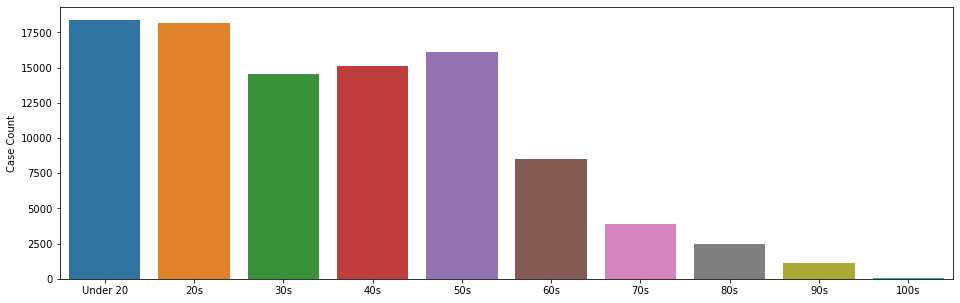

In [263]:
# external communication: Younger generation has the highest infection cases
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=['Under 20','20s','30s','40s','50s','60s','70s','80s','90s','100s'],y = 'Case Count', data = df_all_age)

In [273]:
# Internal communication: close look at Vaughan region, younger population.Younger generation are the majority
df_all_vaughan = df_all.query("Municipality=='Vaughan'")
df_all_vaughan = pd.DataFrame(df_all_vaughan.groupby(['Age Decade','Age_group'])['Case Count'].count())
df_all_vaughan.sort_values(by = 'Age_group')

,,Case Count
Age Decade,Age_group,
Under 20,1.0,7474
20s,2.0,6885
30s,3.0,5039
40s,4.0,5653
50s,5.0,6254
60s,6.0,3247
70s,7.0,1559
80s,8.0,1073
90s,9.0,486


In [283]:
df_all_age_status = pd.DataFrame(df_all.groupby(by=['Age Decade','Status'])['Case Count'].count()).unstack()
df_all_age_status

Case Count                                                      
Status       Deceased Hospitalized Hospitalized-ICU Resolved Self-Isolating
Age Decade                                                                 
100s             14.0          NaN              NaN     34.0            NaN
20s               4.0          1.0              NaN  18121.0           46.0
30s               4.0          NaN              NaN  14459.0           68.0
40s              21.0          NaN              1.0  15036.0           59.0
50s              61.0          2.0              NaN  15954.0           71.0
60s             104.0          3.0              1.0   8324.0           46.0
70s             197.0          5.0              NaN   3673.0           22.0
80s             323.0          5.0              NaN   2156.0           19.0
90s             194.0          NaN              1.0    882.0           11.0
Under 20          1.0          NaN              NaN  18313.0           73.0

In [284]:
df_all_age_status= df_all_age_status.fillna(0)
df_all_age_status

Case Count                                                      
Status       Deceased Hospitalized Hospitalized-ICU Resolved Self-Isolating
Age Decade                                                                 
100s             14.0          0.0              0.0     34.0            0.0
20s               4.0          1.0              0.0  18121.0           46.0
30s               4.0          0.0              0.0  14459.0           68.0
40s              21.0          0.0              1.0  15036.0           59.0
50s              61.0          2.0              0.0  15954.0           71.0
60s             104.0          3.0              1.0   8324.0           46.0
70s             197.0          5.0              0.0   3673.0           22.0
80s             323.0          5.0              0.0   2156.0           19.0
90s             194.0          0.0              1.0    882.0           11.0
Under 20          1.0          0.0              0.0  18313.0           73.0

In [285]:
#resort age groups
df_all_age_status['Age_Group']=df_all_age_status.index.map({'Under 20':1,'20s':2,'30s':3,'40s':4,'50s':5,'60s':6,'70s':7,'80s':8,'90s':9,'100s':10})
df_all_age_status = df_all_age_status.sort_values(by='Age_Group')
df_all_age_status

Case Count                                                        \
Status       Deceased Hospitalized Hospitalized-ICU Resolved Self-Isolating   
Age Decade                                                                    
Under 20          1.0          0.0              0.0  18313.0           73.0   
20s               4.0          1.0              0.0  18121.0           46.0   
30s               4.0          0.0              0.0  14459.0           68.0   
40s              21.0          0.0              1.0  15036.0           59.0   
50s              61.0          2.0              0.0  15954.0           71.0   
60s             104.0          3.0              1.0   8324.0           46.0   
70s             197.0          5.0              0.0   3673.0           22.0   
80s             323.0          5.0              0.0   2156.0           19.0   
90s             194.0          0.0              1.0    882.0           11.0   
100s             14.0          0.0              0.0     34.0            0.0   

           Age_Group  
Status                
Age Decade            
Under 20           1  
20s                2  
30s                3  
40s                4  
50s                5  
60s                6  
70s                7  
80s                8  
90s                9  
100s              10

In [286]:
df_all_age_status.reset_index()

Age Decade Case Count                                         \
Status              Deceased Hospitalized Hospitalized-ICU Resolved   
0        Under 20        1.0          0.0              0.0  18313.0   
1             20s        4.0          1.0              0.0  18121.0   
2             30s        4.0          0.0              0.0  14459.0   
3             40s       21.0          0.0              1.0  15036.0   
4             50s       61.0          2.0              0.0  15954.0   
5             60s      104.0          3.0              1.0   8324.0   
6             70s      197.0          5.0              0.0   3673.0   
7             80s      323.0          5.0              0.0   2156.0   
8             90s      194.0          0.0              1.0    882.0   
9            100s       14.0          0.0              0.0     34.0   

                      Age_Group  
Status Self-Isolating            
0                73.0         1  
1                46.0         2  
2                68.0         3  
3                59.0         4  
4                71.0         5  
5                46.0         6  
6                22.0         7  
7                19.0         8  
8                11.0         9  
9                 0.0        10

In [287]:
df_all_age_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Under 20 to 100s
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   (Case Count, Deceased)          10 non-null     float64
 1   (Case Count, Hospitalized)      10 non-null     float64
 2   (Case Count, Hospitalized-ICU)  10 non-null     float64
 3   (Case Count, Resolved)          10 non-null     float64
 4   (Case Count, Self-Isolating)    10 non-null     float64
 5   (Age_Group, )                   10 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 560.0+ bytes


In [288]:
df_all_age_status['total_count']= df_all_age_status[('Case Count', 'Deceased')]+df_all_age_status[('Case Count', 'Hospitalized')]+df_all_age_status[('Case Count', 'Hospitalized-ICU')]+df_all_age_status[('Case Count', 'Resolved') ]+df_all_age_status[('Case Count', 'Self-Isolating')]
df_all_age_status

Case Count                                                        \
Status       Deceased Hospitalized Hospitalized-ICU Resolved Self-Isolating   
Age Decade                                                                    
Under 20          1.0          0.0              0.0  18313.0           73.0   
20s               4.0          1.0              0.0  18121.0           46.0   
30s               4.0          0.0              0.0  14459.0           68.0   
40s              21.0          0.0              1.0  15036.0           59.0   
50s              61.0          2.0              0.0  15954.0           71.0   
60s             104.0          3.0              1.0   8324.0           46.0   
70s             197.0          5.0              0.0   3673.0           22.0   
80s             323.0          5.0              0.0   2156.0           19.0   
90s             194.0          0.0              1.0    882.0           11.0   
100s             14.0          0.0              0.0     34.0            0.0   

           Age_Group total_count  
Status                            
Age Decade                        
Under 20           1     18387.0  
20s                2     18172.0  
30s                3     14531.0  
40s                4     15117.0  
50s                5     16088.0  
60s                6      8478.0  
70s                7      3897.0  
80s                8      2503.0  
90s                9      1088.0  
100s              10        48.0

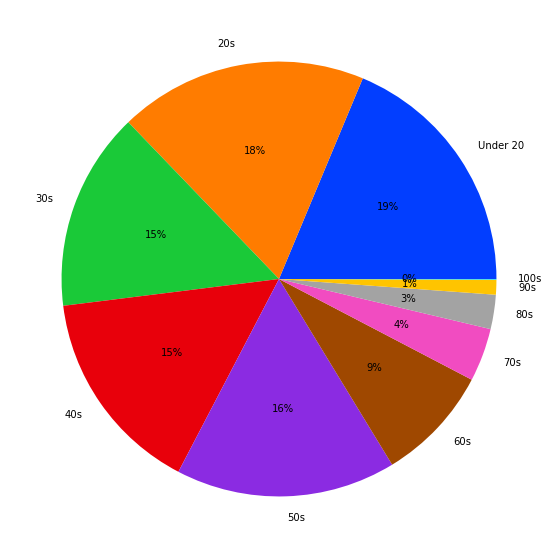

In [289]:
import matplotlib.pyplot as plt
import seaborn

plt.figure(figsize = (11,10))
# define Seaborn color palette to use
palette_color = seaborn.color_palette('bright')
  
# plotting data on chart
plt.pie(df_all_age_status['total_count'], labels=df_all_age_status.index, colors=palette_color, autopct='%.0f%%')
  
# displaying chart
# plt.legend()
plt.show()


In [310]:
df_all_age_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Under 20 to 100s
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   (Case Count, Deceased)          10 non-null     float64
 1   (Case Count, Hospitalized)      10 non-null     float64
 2   (Case Count, Hospitalized-ICU)  10 non-null     float64
 3   (Case Count, Resolved)          10 non-null     float64
 4   (Case Count, Self-Isolating)    10 non-null     float64
 5   (Age_Group, )                   10 non-null     int64  
 6   (total_count, )                 10 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 940.0+ bytes


In [318]:
df_age_decease = df_all_age_status[[('Case Count', 'Deceased'),('Age_Group','')]]
df_age_decease

,Case Count,Age_Group
Status,Deceased,
Age Decade,,
Under 20,1.0,1
20s,4.0,2
30s,4.0,3
40s,21.0,4
50s,61.0,5
60s,104.0,6
70s,197.0,7
80s,323.0,8


In [327]:
df_age_decease = pd.DataFrame(df_age_decease[('Case Count','Deceased')])
df_age_decease

,Case Count
,Deceased
Age Decade,
Under 20,1.0
20s,4.0
30s,4.0
40s,21.0
50s,61.0
60s,104.0
70s,197.0
80s,323.0


<AxesSubplot:xlabel='Age Decade', ylabel="('Case Count', 'Deceased')">

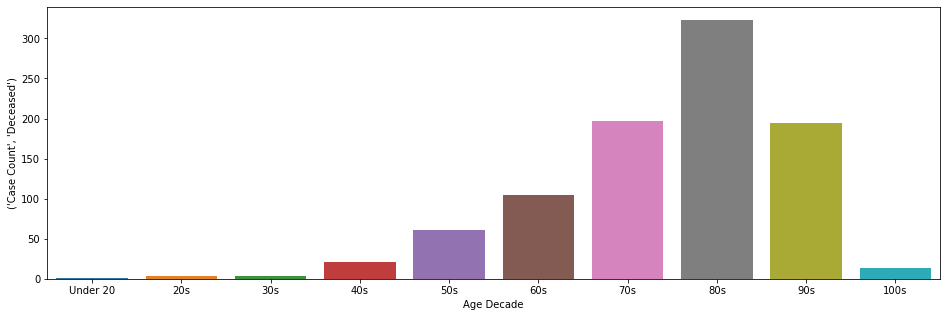

In [332]:
#external communication: 80s has the highest decease rate
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=df_age_decease.index,y = ('Case Count', 'Deceased'), data = df_age_decease)

In [302]:
situation = df_all_age_status[[('Case Count','Deceased'),('Case Count','Hospitalized'),('Case Count','Hospitalized-ICU'),('Case Count','Resolved'),('Case Count','Self-Isolating')]]
situation
df_all_avg_status = []
for i in situation:
    print(i)
    df_all_avg_status.append([i,df_all_age_status[i].mean()])
df_all_avg_status

('Case Count', 'Deceased')
('Case Count', 'Hospitalized')
('Case Count', 'Hospitalized-ICU')
('Case Count', 'Resolved')
('Case Count', 'Self-Isolating')


[[('Case Count', 'Deceased'), 92.3],
 [('Case Count', 'Hospitalized'), 1.6],
 [('Case Count', 'Hospitalized-ICU'), 0.3],
 [('Case Count', 'Resolved'), 9695.2],
 [('Case Count', 'Self-Isolating'), 41.5]]

In [303]:
df_all_avg_status = pd.DataFrame(df_all_avg_status,columns = ['status','average_case_count'])
df_all_avg_status['Status_all_population'] = ['Deceased','Hospitalized','Hospitalized-ICU','Resolved','Self-isolating']
df_all_avg_status

,status,average_case_count,Status_all_population
0,"(Case Count, Deceased)",92.3,Deceased
1,"(Case Count, Hospitalized)",1.6,Hospitalized
2,"(Case Count, Hospitalized-ICU)",0.3,Hospitalized-ICU
3,"(Case Count, Resolved)",9695.2,Resolved
4,"(Case Count, Self-Isolating)",41.5,Self-isolating


<AxesSubplot:title={'center':'average case count - all age population'}, xlabel='Status_all_population'>

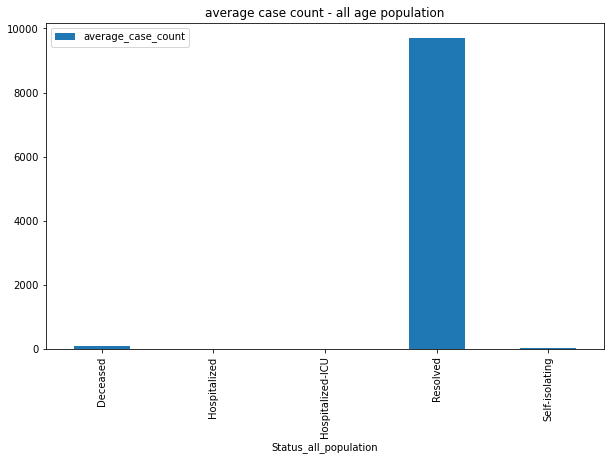

In [304]:
# External communication - age and status combined analysis, resolved is the absolute majority
df_all_avg_status.plot(kind='bar',figsize=(10,6),title='average case count - all age population',x='Status_all_population',y='average_case_count')